In [ ]:
#  Steps of the work:

# Make a model with accessible parameters using TensorFlow 2.x
# Write an entropy loss and add it to the network parameters for training.
# Train a model by jointly optimizing its loss (e.g. cross entropy for classification) and the entropy for compressability.
# Compress the model parameters using Huffman coding.
# Analyze the results and trade-off between accuracy and compressability.
# Write a model wrapper that can read and write the compressed parameters.

# Notes:

# Can be started on simple datasets like MNIST.
# Can start from simple MLP NNs. And then extend to convs. The implementation should be generic enough so that it can support any layer.
# Bonus: add support for normalization layers: batch norm, instance norm, etc.

In [1]:
# Load MNIST data set

from tensorflow.keras.datasets import mnist
train_set, test_set = mnist.load_data()

In [3]:
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# Allocation of 17179869184 exceeds 10% of free system memory.

In [2]:
# generate a simple NN model

from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow import keras
import numpy as np

    
kernel_initializer = 'he_normal'
activation = "relu"

def get_model(chs=256):
    shape=(28,28,1)
    
    inputs = Input(shape)
    layer = Flatten()(inputs)
    layer = Dense(units=chs, activation=activation, kernel_initializer=kernel_initializer)(layer)
    layer = Dense(units=chs, activation=activation, kernel_initializer=kernel_initializer)(layer)
    output = Dense(10, activation='linear', use_bias=True, kernel_initializer=kernel_initializer)(layer)

    model = Model(inputs, output)
    return model



In [1]:
# model.layers

In [23]:
# model.layers[0]

In [5]:
# model.trainable_variables

In [97]:
# tf.reduce_sum(np.arange(100).reshape((10,10)), axis=0, keepdims=True)



<tf.Tensor: shape=(1, 10), dtype=int64, numpy=array([[450, 460, 470, 480, 490, 500, 510, 520, 530, 540]])>

In [26]:
#     To estimate the histogram, we first remove outliers in the
# activations if the samples are outside the range [μ−3σ; μ+3σ]

def calculate_entropy_range(variables, scale = 3):
    std = tf.math.reduce_variance(variables)**0.5
    if std==0.0:
        std = 1.0
    mean = tf.math.reduce_mean(variables)
    return mean - std*scale, mean + std*scale
    
bins = np.arange(256, dtype=np.float32)
bins = tf.convert_to_tensor(bins)
bins = tf.reshape(bins, (1,-1))

# TODO
# change for loop to array way , operation
# matrix way in vector way
# Can't do element by element 
# So do it an array way 
# Write it in array without for loops 
# I can try to implement it in matrix way or vector format in terms using tensorflow 



#     variables (numpy.ndarray): The variables to calculate the weights for.
#     min_h (float): The minimum value of the histogram bins.
#     max_h (float): The maximum value of the histogram bins.
def calculate_weights(variables, min_h, max_h):
    nbins = 256
    deltas = tf.zeros((nbins,variables.shape[0])) # j,k
    t = tf.linspace(0, nbins - 1, nbins) # Return evenly spaced numbers over a specified interval.

    
    # create 2D tensors for x and y array
    x = tf.squeeze(tf.tile(tf.expand_dims(variables, axis=0), [nbins, 1, 1]), axis=-1)# 256, 65536
    y = tf.tile(tf.expand_dims(t, axis=1), [1, variables.shape[0]]) # 256, 65536
    
    tj = y
    tj1 = tf.clip_by_value(y - 1, 0, nbins - 1)
    tj2 = tf.clip_by_value(y + 1, 0, nbins - 1)
    w = weight(x, tj, tj1, tj2, nbins)
    deltas = w

    return deltas

# 
#         xk (float): The input value to calculate the weight for.
#         tj (float): The current node.
#         tj1 (float): The previous node.
#         tj2 (float): The next node.
#    if xk ∈ [tj−1; tj ] then (xk − tj−1)/Δ
#     if xk ∈ [tj ; tj+1] then (tj+1 − xk)/Δ
#     otherwise return 0
def weight(xk, tj, tj1, tj2, nbins):
    xk = tf.cast(xk, tf.float32)
    tj = tf.cast(tj, tf.float32)
    tj1 = tf.cast(tj1, tf.float32)
    tj2 = tf.cast(tj2, tf.float32)
    delta = 1.0 / nbins
#     print('xk: ' + str(xk) + ',tj: ' + str(tj) + ',tj1: ' + str(tj1) + ',tj2: ' + str(tj2) + ',delta: ' + str(tj2 - tj1))
#     if tj1 <= xk and xk <= tj:
# #         print('1: ' + str((xk - tj1) / delta))
#         return (xk - tj1) / delta
#     elif tj <= xk and xk <= tj2:
# #         print('2: ' + str((tj2 - xk) / delta))
#         return (tj2 - xk) / delta
#     else:
#         return 0.0

    # Create boolean masks
    mask1 = tf.logical_and(tj1 <= xk, xk <= tj)
    mask2 = tf.logical_and(tj <= xk, xk <= tj2)

    # Calculate weights using boolean masks
    weights1 = tf.where(mask1, (xk - tj1) / delta, tf.zeros_like(xk))
    weights2 = tf.where(mask2, (tj2 - xk) / delta, tf.zeros_like(xk))

    # Create boolean mask for else statement
    mask3 = tf.logical_not(tf.logical_or(mask1, mask2))

    # Calculate weights for else statement using boolean mask
    weights3 = tf.where(mask3, tf.zeros_like(xk), tf.ones_like(xk) * 0.0)
    
    # Return sum of weights
    return tf.reduce_sum(weights1 + weights2 + weights3, axis=-1)

def calculate_histogram(variables, min_h, max_h):
    flat_vars = tf.reshape(variables, (-1,1))
    scaled_vars = (flat_vars-min_h)*255/(max_h-min_h)
    cacl_w = calculate_weights(scaled_vars, min_h, max_h)
#     diff = tf.reshape(diff, (-1,1))
#     diff = tf.cast(diff, tf.float32)
#     diff = bins - diff
#     print(diff) # shape = (256,) -> (65536, 1) or (16777216, 1)
#     print(np.count_nonzero(diff))
# (16777216, 1), dtype=float32)
# 512
#     diff = bins - scaled_vars
#     print(bins) # shape = (1,256)
#     print(scaled_vars) # shape=(65536, 1)
#     print(bins - scaled_vars) # shape=(65536, 256)
#     print(bins - diff) # shape=(1, 256)
#     diff = bins - cacl_w
#     p_ = tf.exp(-(diff**2))
#     p = p_ / (tf.reduce_sum(p_, axis=1, keepdims=True)+1e-10)
#     p = tf.expand_dims(p, axis=1)
#  just using scaled_vars
    diff = bins - scaled_vars
    p_ = tf.exp(-(diff**2))
    p = p_ / (tf.reduce_sum(p_, axis=1, keepdims=True)+1e-10)

    hist = tf.reduce_sum(p, axis=0)

    return hist

def calculate_entropy(variables, eps=1e-10):
#     print(variables)
#     variables shape (784, 256)
#     print('gg')
    # TODO implement
    # here you need to also output the range of the compressed data (minimum, maximum)
#     return 0
    # Calculate the histogram of the variables
#     hist, bin_edges = np.histogram(variables, bins='auto')
    
#     # Convert the histogram to probabilities
#     probs = hist / np.sum(hist)
    
#     # Calculate the entropy
#     entropy = -np.sum(probs * np.log2(probs))
    
#     # Calculate the range of the compressed data
#     compressed_range = (bin_edges[0], bin_edges[-1])
# #     print(entropy, '      :::: ', compressed_range)
    
#     return entropy, compressed_range
    flat_vars = tf.reshape(variables, (-1,1))
    min_h, max_h = calculate_entropy_range(variables)
    
    hist = calculate_histogram(flat_vars, min_h, max_h)
    #hist = tf.histogram_fixed_width(flat_vars, [min_h,max_h])
    
    probs = hist / tf.reduce_sum(hist)
#     probs[probs == 0] = 1  # replace zeros with ones
    entropy = -tf.reduce_sum(probs * tf.experimental.numpy.log2(probs+eps))
#     print(entropy,':: ', np.min(flat_vars),':: ', np.max(flat_vars),':: ', bins[0],':: ',bins[1])
    return entropy, (min_h, max_h)

class CompressibleNN(keras.Model):
    def __init__(self, net_model):
        super(CompressibleNN, self).__init__()
        self.net_model = net_model
        self.CE_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    def call(self, inputs):
        return self.net_model(inputs)
    
    def entropy_loss(self, inputs):
        # TODO implemment the entropy calculation here for each layer parameters
        # for each layer: calculate a histogram and from then calculate the entropy
        # return a sum of all entropies
        
        entropy = 0
#         for l in self.net_model.layers:
#             #TODO: if layer is dense:
#             for v in l.trainable_variables:
#                 # here you have a set of variable for which you can calculate the histogram and entropy
#                 entropy += calculate_entropy(v)
#         return 0
        for l in self.net_model.layers:
            if isinstance(l, keras.layers.Dense):
                for v in l.trainable_variables:
                    v_entropy, v_range = calculate_entropy(v)
                    entropy += v_entropy

        return entropy

    
    
    def train_step(self, input):
        images = input[0]
        labels = input[1]

        with tf.GradientTape() as tape:
            output = self.net_model(images)
            loss =  self.entropy_loss(images)

        # Get the gradients w.r.t the loss
        gradient = tape.gradient(loss, self.net_model.trainable_variables)
        # Update the weights using the generator optimizer
        self.optimizer.apply_gradients(
            zip(gradient, self.net_model.trainable_variables)
        )
        return {"loss": loss}
    
model = get_model()
compNN = CompressibleNN(model)
optimizer = tf.optimizers.Adam(learning_rate=1e-3, beta_1=0.9)
compNN.compile(optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [28]:
min_h, max_h = calculate_entropy_range(model.layers[3].variables[0])
our_h=calculate_histogram(model.layers[3].variables[0], min_h, max_h)


In [20]:
np_h=np.histogram(model.layers[3].variables[0], bins=256) # shape 256 * 257
np_h[0]
print(np_h[0].shape)

(256,)


In [24]:
our_h = tf.reshape(our_h,(-1,1))
our_h

<tf.Tensor: shape=(256, 1), dtype=float32, numpy=
array([[7.2133487e-01],
       [2.6536426e-01],
       [1.3211709e-02],
       [8.9019792e-05],
       [8.1175543e-08],
       [1.0017858e-11],
       [1.6731527e-16],
       [3.7818762e-22],
       [1.1568847e-28],
       [4.7894306e-36],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000

In [14]:
np_h[0]

array([ 68,  64,  50,  56,  66,  77,  61,  64,  66,  60,  84,  74,  83,
        98,  94,  89,  91,  87,  95, 110, 102, 125, 105, 111, 115, 114,
       109, 113, 131, 118, 134, 134, 144, 147, 150, 148, 137, 152, 149,
       155, 169, 169, 182, 168, 184, 193, 174, 221, 198, 189, 208, 198,
       229, 219, 230, 220, 247, 220, 224, 224, 259, 234, 228, 256, 244,
       282, 238, 287, 296, 280, 305, 288, 268, 288, 306, 304, 298, 326,
       334, 341, 330, 316, 303, 363, 322, 324, 334, 359, 349, 366, 355,
       370, 319, 387, 356, 381, 378, 380, 363, 377, 400, 435, 415, 426,
       394, 410, 418, 419, 415, 417, 409, 394, 382, 427, 401, 410, 423,
       414, 386, 424, 452, 436, 424, 424, 440, 399, 423, 410, 443, 455,
       429, 434, 419, 401, 399, 392, 434, 444, 436, 426, 428, 453, 446,
       444, 418, 417, 392, 406, 397, 395, 359, 416, 363, 370, 357, 383,
       364, 383, 405, 395, 429, 402, 404, 360, 418, 391, 366, 347, 356,
       336, 364, 323, 323, 348, 345, 395, 351, 324, 323, 322, 30

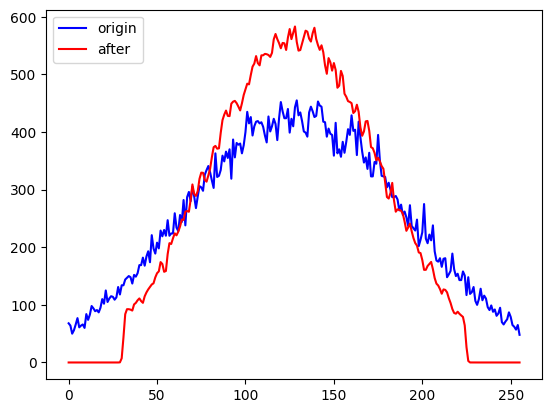

In [31]:
from matplotlib import pyplot as plt
plt.plot(np_h[0], "-b", label="origin")
plt.plot(our_h, "-r", label="after")
plt.legend(loc="upper left")
plt.show()


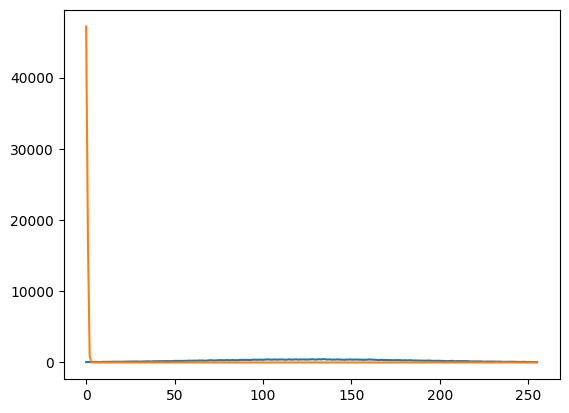

In [15]:
plt.plot(np_h[0])
plt.plot(our_h)

In [7]:
# train the model
tf.config.run_functions_eagerly(True)
# loss needs to be decreased during training
compNN.fit(x=train_set[0], y=train_set[1], epochs=1, batch_size=32)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


   3/1875 [..............................] - ETA: 3:49:25 - loss: 26.4757

KeyboardInterrupt: 

In [53]:
# test performance
res = model(test_set[0])
print("test acc: ", 100*(np.argmax(res, axis=1)==test_set[1]).mean())

test acc:  96.02000000000001


In [56]:
# test performance with entropy_loss
res = model(test_set[0])
print("test acc: ", 100*(np.argmax(res, axis=1)==test_set[1]).mean())

test acc:  96.61
